# DeepLabV3 VOC 2012 and SBD 

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import my_datasets as mdset
import eval_train as ev
from utils import * 




## Dataset : Pascal VOC 2012

In [2]:
dataroot_voc = '/data/voc2012'
dataroot_sbd = '/data/sbd'
model_name = 'fcn_voc_sbd_30.pt'
SAVE_DIR = '/data/model'
save = os.path.join(SAVE_DIR,model_name)
batch_size = 4


In [3]:
train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train', download=True,rotate=False)

val_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [4]:
train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation',rotate=True)

val_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='val',mode='segmentation')

### Concatene dataset

In [5]:
train_dataset = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])

### Split dataset

In [6]:
train_dataset = split_dataset(train_dataset,0.3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([500, 500, 3])


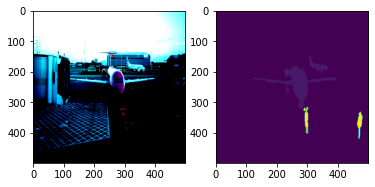

torch.Size([500, 500])

In [7]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = train_dataset_VOC.__getitem__(0)
image, mask = sample[0], sample[1]
#print(type(image))
#print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [8]:
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset_VOC, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [9]:
print("Taille dataset train VOC + SBD :",len(train_dataset))
print("Taille dataset val VOC :",len(val_dataset_VOC))

Taille dataset train VOC + SBD : 2126
Taille dataset val VOC : 1449



## DeepLabV3 Pytorch

In [10]:
model = torchvision.models.segmentation.fcn_resnet101(pretrained=False)
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Training

In [11]:
learning_rate = 10e-4
moment = 0.9
wd = 5e-4
n_epochs = 26
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [12]:
iou_train = []
loss_train = []
iou_test = []
loss_test = []
accuracy_test = []
all_loss_train = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)
    model.train()
    for i,(x,mask) in enumerate(dataloader_train):
        x = x.to(device)
        mask = mask.to(device)  
        pred = model(x)
        pred = pred["out"]
        loss = criterion(pred,mask)
        all_loss_train.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        all_iou.append(inter_over_union(pred.argmax(dim=1).detach().cpu(),mask.detach().cpu()))
        optimizer.step()        
        
    #lr_scheduler.step()
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_train).mean()
    loss_train.append(m_loss)
    iou_train.append(m_iou)
    all_loss_train = []
    all_iou = []
    print("EP:",ep," loss train:",m_loss," iou train:",m_iou)
    
    #Eval model
    
    model.eval()
    state = ev.eval_model(model,dataloader_val,device=device,num_classes=21,batch_size=batch_size)
    iou = state.metrics['mean IoU']
    acc = state.metrics['accuracy']
    loss = state.metrics['CE Loss'] 
    loss_test.append(loss)
    iou_test.append(iou)
    accuracy_test.append(acc)
    print('EP:',ep,'iou:',state.metrics['mean IoU'],\
          'Accuracy:',state.metrics['accuracy'],'Loss CE',state.metrics['CE Loss'])
    
    torch.save(model,save)
    

EPOCH 0


/workspace/utils.py:117: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(area_inter/area_union)


## Plot

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DeepLabV3 30% VOC SBD mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")